In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load the data

To avoid features being derived from other features split the data into subsets *mean_* and *percent_* features.

In [69]:
df = pd.read_csv("./data/processed/raw.csv")
df.drop(["school", "q1", "q3", "grade"], axis=1, inplace=True)
X = df.drop(["name", "event", "place", "all_american", "score"], axis=1)
X["year"] /= 4

y_score = df["score"]
y_all_am = df["all_american"]

In [70]:
# Prepare scaled data for later
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = list(X.columns[:-1]) # Year scaling is dividing by 4
X_scaled_np = scaler.fit_transform(X.drop(["year"], axis=1))
X_scaled = pd.DataFrame(X_scaled_np, columns=columns)
X_scaled = pd.concat([df[["all_american", "score"]], X_scaled, df["year"]], axis=1)

In [ ]:
df_means = df.drop(["name", "place", "percent_diff_recent_best", "percent_diff_recent_worst"], axis=1)
df_means.head(2)

In [44]:
df_percents = df.drop(["name", "place", "mean_three_recent", "mean_three_best", "mean_three_worst"], axis=1)
df_percents.head(2)

,event,all_american,min,max,mean,std,median,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year,score
0,100,1,0.939713,0.982000,0.966135,0.011727,0.966536,0.013292,0.017410,0.0,16,2,1.000000
1,100,1,0.964637,1.003064,0.974430,0.011425,0.971316,0.000230,0.007804,0.0,9,1,0.958333


## Dimensionality Reduction

### Correlation
Check if any features are highly correlated

In [68]:
X_correlations = df.drop(["name", "place"], axis=1).corr(numeric_only=True)
X_correlations[abs(X_correlations) > 0.4]

,all_american,min,max,mean,std,median,mean_three_recent,mean_three_best,mean_three_worst,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year,score
all_american,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814729
min,NaN,1.000000,0.746160,0.868393,-0.863812,0.839157,0.868393,0.757867,0.958043,-0.742832,-0.834228,NaN,NaN,NaN,NaN
max,NaN,0.746160,1.000000,0.945981,NaN,0.941817,0.945981,0.979613,0.832441,-0.402534,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.868393,0.945981,1.000000,-0.608691,0.994070,1.000000,0.957523,0.951560,-0.633585,-0.566721,NaN,NaN,NaN,NaN
std,NaN,-0.863812,NaN,-0.608691,1.000000,-0.565123,-0.608691,-0.427707,-0.791583,0.805915,0.915533,NaN,NaN,NaN,NaN
median,NaN,0.839157,0.941817,0.994070,-0.565123,1.000000,0.994070,0.956692,0.930132,-0.616570,-0.517846,NaN,NaN,NaN,NaN
mean_three_recent,NaN,0.868393,0.945981,1.000000,-0.608691,0.994070,1.000000,0.957523,0.951560,-0.633585,-0.566721,NaN,NaN,NaN,NaN
mean_three_best,NaN,0.757867,0.979613,0.957523,-0.427707,0.956692,0.957523,1.000000,0.841396,NaN,NaN,NaN,NaN,NaN,NaN
mean_three_worst,NaN,0.958043,0.832441,0.951560,-0.791583,0.930132,0.951560,0.841396,1.000000,-0.786998,-0.789165,NaN,NaN,NaN,NaN
percent_diff_recent_best,NaN,-0.742832,-0.402534,-0.633585,0.805915,-0.616570,-0.633585,NaN,-0.786998,1.000000,0.861893,NaN,0.557427,NaN,NaN


Observations
- The min, max, mean, and median are highly correlated as expected. Consider selecting only one of the four.
- The three *mean_* features highly correlated with min, max, mean, and median so they may not be very descriptive
- The *percent_diff*  features have a strong negative correlation with min, max, mean, median
- The *percent_diff*  features are highly correlated with standard deviation and count which was not expected

In [39]:
# Observe which features correlate best with target
X_correlations["score"]

all_american                 0.814729
min                          0.122397
max                          0.286176
mean                         0.207847
std                          0.034175
median                       0.208468
mean_three_recent            0.207847
mean_three_best              0.268128
mean_three_worst             0.138837
percent_diff_recent_best     0.054832
percent_diff_recent_worst    0.036084
no_mark_rate                -0.148302
count                        0.122951
year                         0.035511
score                        1.000000
Name: score, dtype: float64

In [41]:
# Based on correlation alone, the only descriptive statistic needed is mean so our feature reduced data would be
X_fr_correlation = df[["event", "all_american", "score", "mean", "std", "percent_diff_recent_best", "percent_diff_recent_worst", "no_mark_rate", "count", "year"]]
X_fr_correlation.head(2)

,event,all_american,score,mean,std,percent_diff_recent_best,percent_diff_recent_worst,no_mark_rate,count,year
0,100,1,1.000000,0.966135,0.011727,0.013292,0.017410,0.0,16,2
1,100,1,0.958333,0.974430,0.011425,0.000230,0.007804,0.0,9,1


### PCA
See if either subset can be well approximated with fewer dimensions 

In [97]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [114]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)
np.cumsum(pca.explained_variance_ratio_)

array([0.99944375, 0.99978942, 0.99996606, 0.99998224, 0.99999642,
       0.99999869, 0.99999941, 0.99999979, 0.99999989, 0.99999995,
       0.99999999, 1.        , 1.        ])

In [121]:
# Proof that the count feature in unscaled form was too much
# 99% variance with 5 features
X_count_scaled = X.copy()
X_count_scaled["count"] = X_scaled["count"].copy()

pca = PCA(n_components=X.shape[1])
pca.fit(X_count_scaled)
np.cumsum(pca.explained_variance_ratio_)

array([0.5363202 , 0.79807738, 0.95851262, 0.97844427, 0.99559703,
       0.99838493, 0.99927716, 0.99973622, 0.99985991, 0.9999376 ,
       0.99998206, 1.        , 1.        ])

In [122]:
# Try PCA with all scaled
# 99% variance with 7 features
pca = PCA(n_components=X_scaled.shape[1])
pca.fit(X_scaled)
np.cumsum(pca.explained_variance_ratio_)

array([0.59059757, 0.79225125, 0.93488583, 0.95773049, 0.97441762,
       0.98670203, 0.99598333, 0.99836088, 0.9992041 , 0.99959171,
       0.99983998, 0.99993166, 0.99998767, 1.        , 1.        ])

In conclusion, scaled or unscaled PCA should be highly effective for our data.

In [73]:
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, RandomizedSearchCV

# Need the binary class target for KNN but will try "continuous" score for regression
X_train, X_test, y_score_train, y_score_test = train_test_split(X_scaled, y_score, test_size=4/18, random_state=0, stratify=df["event"])
_, _, y_all_am_train, y_all_am_test = train_test_split(X_scaled, y_all_am, test_size=4/18, random_state=0, stratify=df["event"])
assert sum([1 if x > 0.7 else 0 for x in y_score_train] == y_all_am_train) # assert we got data in the same order thus we don't need second Xs

print(X_train.shape, X_test.shape)

(334, 15) (96, 15)


## Model 1 - KNN

## Model 2 - Decision Tree

## Model 3 - SVM

We can make two simple arguments about correctness of predictons before training any model. We know, that the predictions should not go above 1. Secondly, our labels are uniformly distributed so our predictions should be as well.

In [ ]:
plt.histogram(y_score_test, bins=8, c='b')
ptt.historam(y_score_all_am, bins=8, c='o')
plt.show()

In [123]:
from sklearn.svm import SVC, SVR

In [119]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_all_am_train)

SVC(kernel='linear')

In [122]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
predictions = svm.predict(X_train)
print(accuracy_score(predictions, y_all_am_train))
print(f1_score(y_all_am_train, predictions))

1.0
1.0


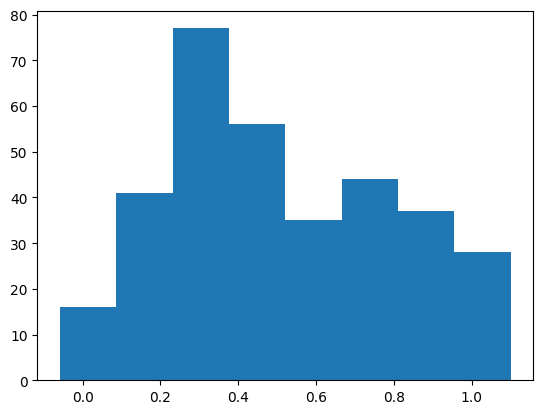

In [132]:
svm = SVR(kernel="poly", degree=5)
svm.fit(X_train, y_score_train)
plt.hist(svm.predict(X_train), bins=8)
plt.show()

In [133]:
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error
predictions = svm.predict(X_train)
sorted(predictions, reverse=True)[:10]
# for metric in [max_error, mean_squared_error, mean_absolute_error]:
#     print(metric(predictions, y_score_train))


[1.1004778278400194,
 1.1002894115507702,
 1.1001437810721248,
 1.0998833665654135,
 1.099821971593929,
 1.0996933983397228,
 1.0931263409963858,
 1.068980302781321,
 1.0598735614186148,
 1.055958833548002]

In [133]:
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error
predictions = svm.predict(X_train)
sorted(predictions, reverse=True)[:10]
# for metric in [max_error, mean_squared_error, mean_absolute_error]:
#     print(metric(predictions, y_score_train))


[1.1004778278400194,
 1.1002894115507702,
 1.1001437810721248,
 1.0998833665654135,
 1.099821971593929,
 1.0996933983397228,
 1.0931263409963858,
 1.068980302781321,
 1.0598735614186148,
 1.055958833548002]